# Double Machine Learning meets Panel Data - Promises, Pitfalls, and Potential Solutions
by Jonathan Fuhr and Dominik Papies

Abstract
Estimating causal effect using machine learning (ML) algorithms can help to relax functional
form assumptions if used within appropriate frameworks. However, most of these frameworks
assume settings with cross-sectional data, whereas researchers often have access to panel data,
which in traditional methods helps to deal with unobserved heterogeneity between units. In this
paper, we explore how we can adapt double/debiased machine learning (DML) (Chernozhukov
et al., 2018) for panel data in the presence of unobserved heterogeneity. This adaptation is challenging
because DML’s cross-fitting procedure assumes independent data and the unobserved
heterogeneity is not necessarily additively separable in settings with nonlinear observed confounding.
We assess the performance of several intuitively appealing estimators in a variety of
simulations. While we find violations of the cross-fitting assumptions to be largely inconsequential
for the accuracy of the effect estimates, many of the considered methods fail to adequately
account for the presence of unobserved heterogeneity. However, we find that using predictive
models based on the correlated random effects approach (Mundlak, 1978) within DML leads to
accurate coefficient estimates across settings, given a sample size that is large relative to the
number of observed confounders. We also show that the influence of the unobserved heterogeneity
on the observed confounders plays a significant role for the performance of most alternative
methods.

# Simulation Study with DoubleML and Panel Data

## DGP

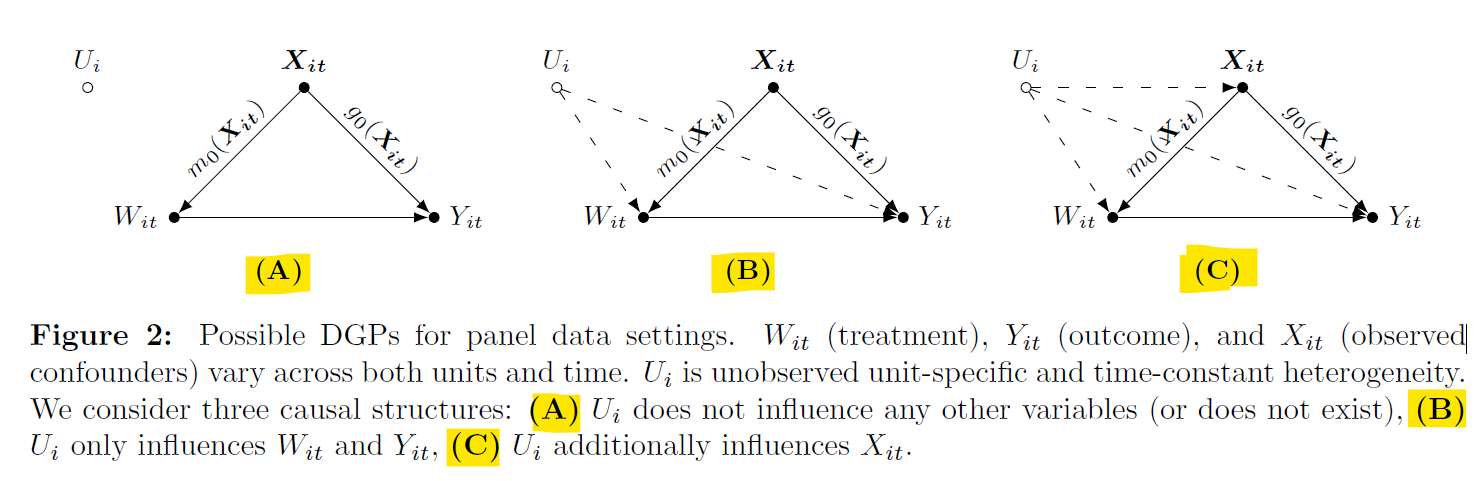

In [1]:
import numpy as np
import pandas as pd

def generate_data(
    N=100,
    T=50,
    unobserved_heterogeneity=False,
    unobserved_heterogeneity_on_covariates=False,
    nonlinear=False,
    autocorrelation=0.0,
    seed=42
):
    """
    Generates panel data for simulation.

    Parameters:
    - N: Number of units
    - T: Number of periods
    - unobserved_heterogeneity: If True, introduces unit-specific unobserved heterogeneity
    - nonlinear: If True, introduces non-linear confounding
    - autocorrelation: AR(1) coefficient for serially correlated errors in outcome
    - seed: Random seed for reproducibility

    Returns:
    - DataFrame containing the generated panel data with columns ['unit', 'time', 'Y', 'W', 'X', 'U']
    """
    np.random.seed(seed)
    alpha = np.random.normal(0, 1, 3)
    beta = 1.0
    gamma = np.random.normal(0, 1, 1)
    delta = np.random.normal(0, 1, 1)

    # Generate unobserved heterogeneity (unit-specific)
    U = np.random.normal(0, 1, N) if unobserved_heterogeneity else np.zeros(N)

    # Generate observed confounders (time-varying)
    X = alpha[0] + np.random.normal(0, 1, (N, T))
    if unobserved_heterogeneity_on_covariates:
        X += delta * U[:, None]
    if nonlinear:
        X = X ** 2

    # Generate treatment variable
    W = alpha[1] + gamma * X + delta * U[:, None] + np.random.normal(0, 1, (N, T))

    # Generate outcome variable with AR(1) process for error
    errors = np.random.normal(0, 1, (N, T))
    Y = np.zeros((N, T))
    Y[:, 0] = alpha[2] + beta * W[:, 0] + gamma * X[:, 0] + delta * U + errors[:, 0]
    for t in range(1, T):
        Y[:, t] = (
            alpha[2] + beta * W[:, t] + gamma * X[:, t] + delta * U +
            autocorrelation * errors[:, t - 1] + errors[:, t]
        )

    # Reshape and return as a DataFrame
    data = pd.DataFrame({
        'unit': np.repeat(np.arange(N), T),
        'time': np.tile(np.arange(T), N),
        'Y': Y.flatten(),
        'W': W.flatten(),
        'X': X.flatten(),
        'U': np.repeat(U, T)  # Unobserved heterogeneity for validation only
    })
    return data


In [5]:
N = 100
T = 5
n_runs = 100

In [9]:
test_df = generate_data(N=N, T=T, seed=42, unobserved_heterogeneity=True, unobserved_heterogeneity_on_covariates=True, nonlinear=True, autocorrelation=0.9)
test_df.head(50)

,unit,time,Y,W,X,U
0,0,0,4.237472,3.184111,0.913150,-0.234137
1,0,1,17.623346,8.193373,5.942498,-0.234137
2,0,2,0.478516,-0.525086,0.527244,-0.234137
3,0,3,-0.737467,-0.865148,0.654624,-0.234137
4,0,4,4.161091,1.759271,0.227617,-0.234137
5,1,0,10.013453,5.036274,3.210673,1.579213
6,1,1,-0.209179,-0.548268,0.010085,1.579213
7,1,2,1.222301,-0.174720,0.035031,1.579213
8,1,3,20.359208,8.584512,6.709023,1.579213
9,1,4,2.825191,1.944229,0.004280,1.579213


## Oracle

In [3]:
import statsmodels.api as sm

def estimate_effect(data):
    model = sm.OLS(data['Y'], sm.add_constant(data[['W', 'X', 'U']]))
    result = model.fit()
    return result.params['W']

In [4]:
oracle_results = []
for _ in range(100):
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N,
        T=T, 
        unobserved_heterogeneity=True,
        unobserved_heterogeneity_on_covariates=True,
        nonlinear=True,
        autocorrelation=0.9,
        seed=seed
        )
    oracle_results.append(estimate_effect(data))

In [5]:
results_df_or = pd.DataFrame({"Oracle": oracle_results})
results_df_or.mean()

Oracle    0.999184
dtype: float64

C:\Users\Work\AppData\Local\Temp\ipykernel_32992\1933644194.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


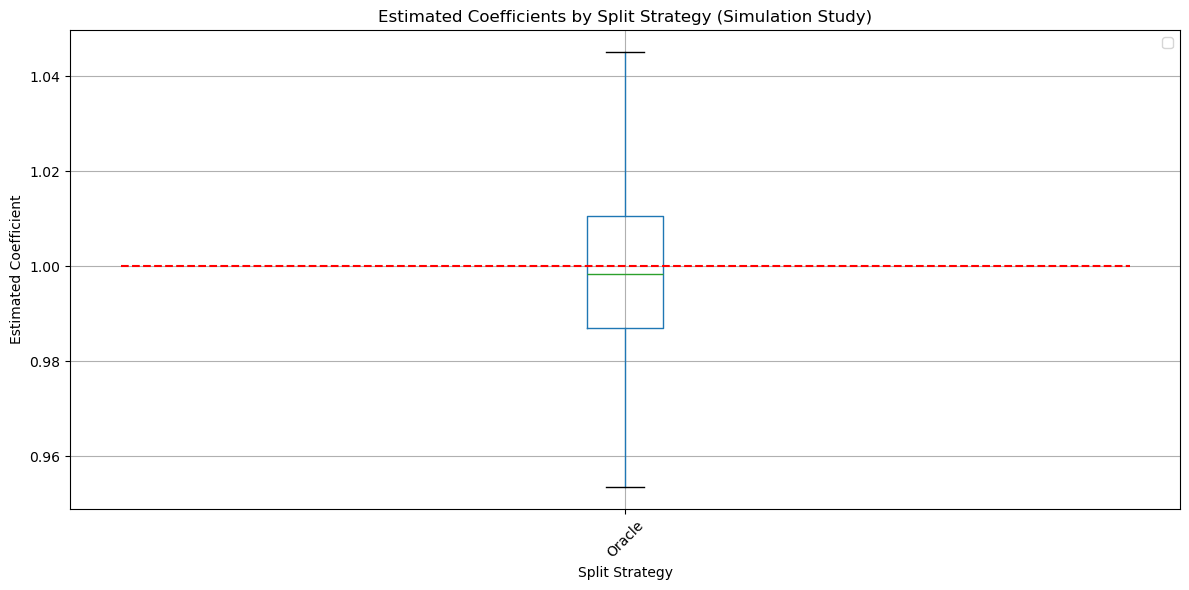

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
results_df_or.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.xticks(rotation=45)
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=2)
plt.legend()
plt.tight_layout()
plt.show()

# Simulation Results

In [7]:
split_strategies = ["random", "by_time", "by_unit", "time_adjacent", "neighbors_left_out"]
results = {strategy: [] for strategy in split_strategies}

## Standard-DML

In [8]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from doubleml import DoubleMLPLR, DoubleMLData


for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N, 
        T=T, 
        unobserved_heterogeneity=True,
        unobserved_heterogeneity_on_covariates=True, 
        nonlinear=True, 
        autocorrelation=0.9,
        seed=seed
        )
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        data, 
        y_col='Y', 
        d_cols='W', 
        x_cols=['X'], 
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [9]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.351585
by_time               1.348735
by_unit               1.360496
time_adjacent         1.348839
neighbors_left_out    1.356614
dtype: float64

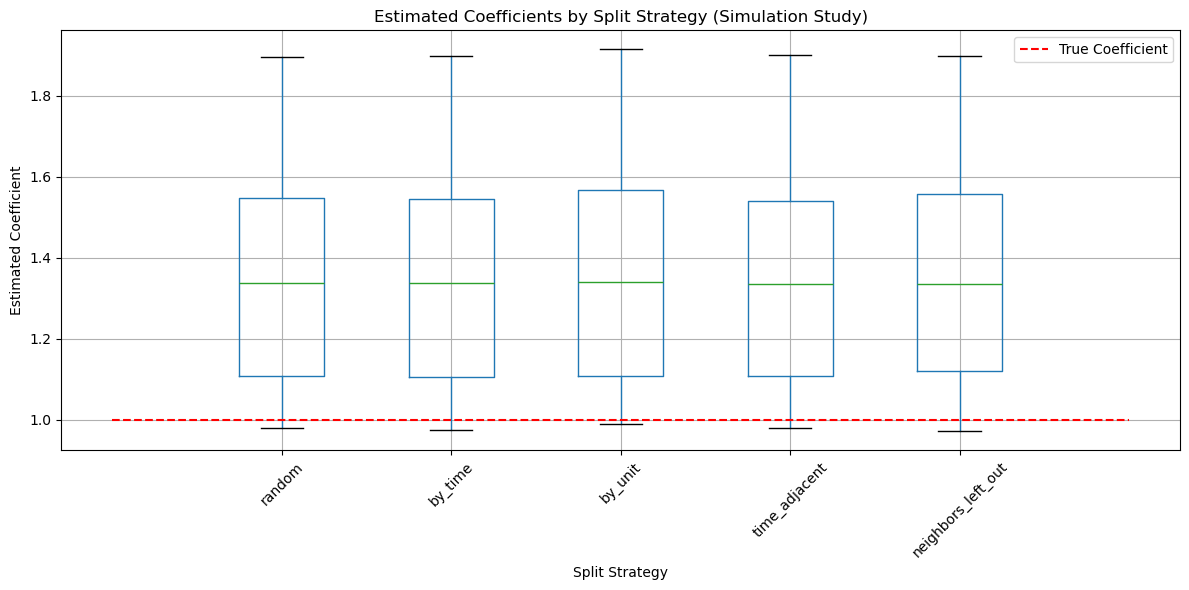

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Dummy-DML

In [11]:
for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N, 
        T=T, 
        unobserved_heterogeneity=True,
        unobserved_heterogeneity_on_covariates=True,
        nonlinear=True, 
        autocorrelation=0.9,
        seed=seed
        )
    unit_dummies = pd.get_dummies(data["unit"], drop_first=False)
    unit_dummy_cols = list(unit_dummies.columns)
    dummy_data = pd.concat([data, unit_dummies], axis=1)
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        dummy_data, 
        y_col='Y',
        d_cols='W', 
        x_cols=['X'] + unit_dummy_cols, 
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [12]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.234250
by_time               1.230174
by_unit               1.360697
time_adjacent         1.231763
neighbors_left_out    1.239201
dtype: float64

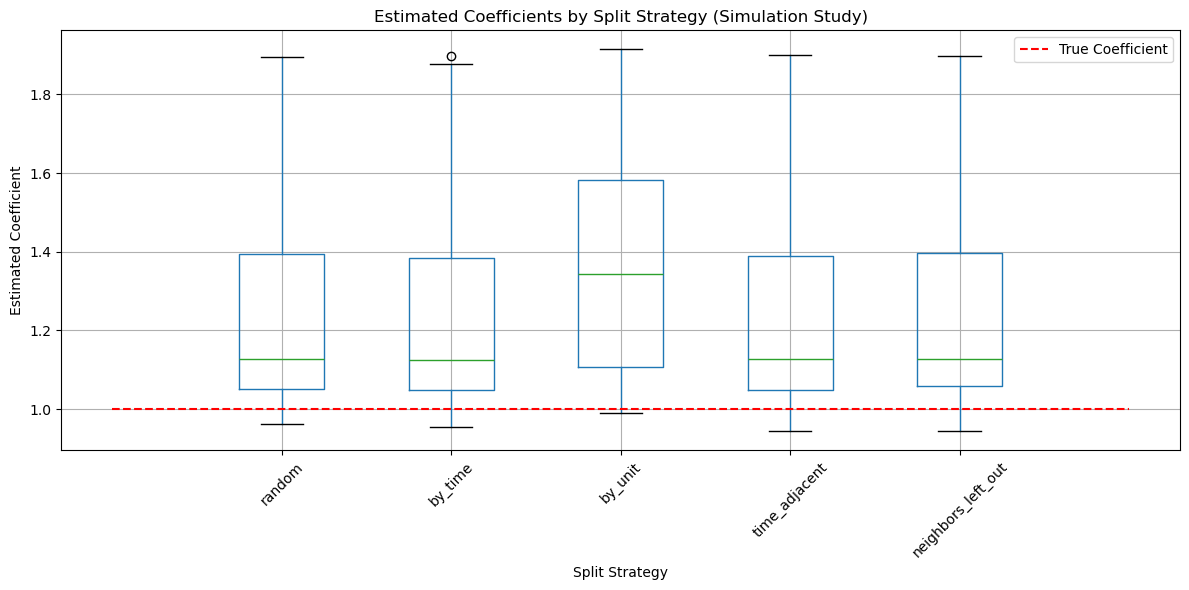

In [13]:
plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Early-Demeaned-DML

In [14]:
for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N, 
        T=T, 
        unobserved_heterogeneity=True,
        unobserved_heterogeneity_on_covariates=True,
        nonlinear=True, 
        autocorrelation=0.9,
        seed=seed
    )

    data['Y'] = data['Y'] - data.groupby('unit')['Y'].transform('mean')
    data['X'] = data['X'] - data.groupby('unit')['X'].transform('mean')
    data['W'] = data['W'] - data.groupby('unit')['W'].transform('mean')
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        data,
        y_col='Y',
        d_cols='W', 
        x_cols=['X'], 
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [15]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.185135
by_time               1.181123
by_unit               1.269531
time_adjacent         1.182267
neighbors_left_out    1.189752
dtype: float64

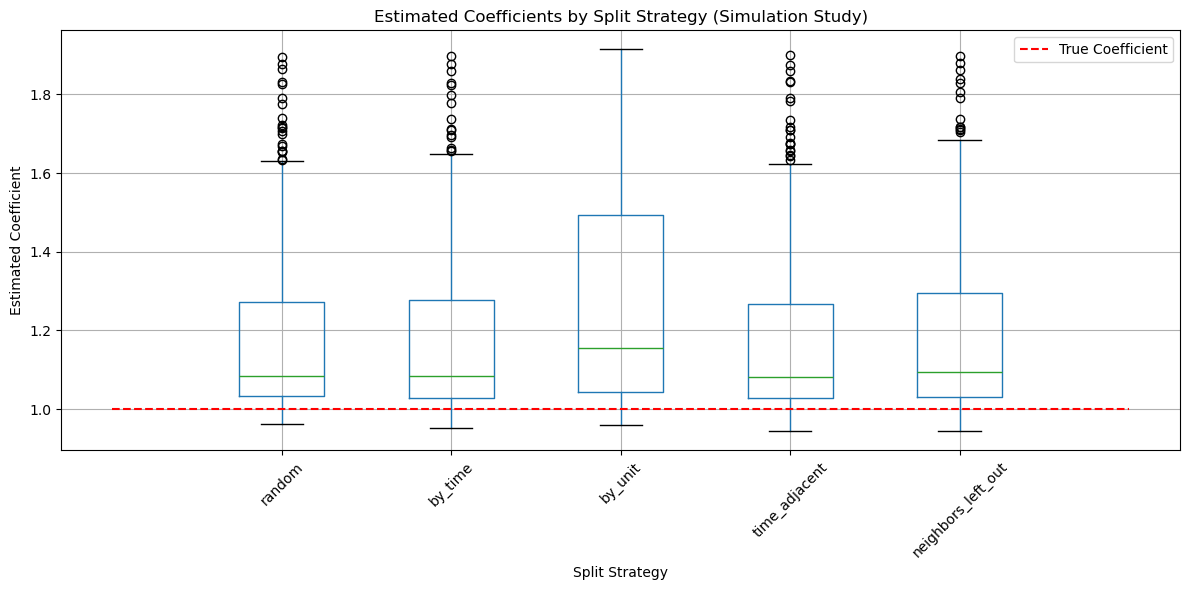

In [16]:
plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## CRE?

In [ ]:
for _ in range(n_runs):
    # Generate dataset
    seed = np.random.randint(1000, 10000)
    data = generate_data(
        N=N,
        T=T, 
        unobserved_heterogeneity=True,
        unobserved_heterogeneity_on_covariates=False,
        nonlinear=True, 
        autocorrelation=0.2,
        seed=seed
    )

    X_mean = data.groupby("unit")["X"].transform("mean")
    W_mean = data.groupby("unit")["W"].transform("mean")

    data['X_mean'] = X_mean
    data['W_mean'] = W_mean
    
    # Prepare DoubleMLData object
    dml_data = DoubleMLData(
        data,
        y_col='Y',
        d_cols='W',
        x_cols=['X' , 'X_mean', 'W_mean'], # mean of W only for ml_m estimation?
        t_col="time", 
        u_col="unit"
        )
    
    for strategy in split_strategies:
        # Fit DoubleMLPLR model
        model = DoubleMLPLR(
            dml_data, 
            ml_l=LGBMRegressor(verbose=-1), 
            ml_m=LGBMRegressor(verbose=-1), 
            n_folds=3, 
            split_strategy=strategy
            )
        model.fit()
    
        results[strategy].append(model.coef[0])

In [18]:
results_df = pd.DataFrame({strategy: results[strategy] for strategy in split_strategies})
results_df.mean()

random                1.148887
by_time               1.145888
by_unit               1.217022
time_adjacent         1.146058
neighbors_left_out    1.153722
dtype: float64

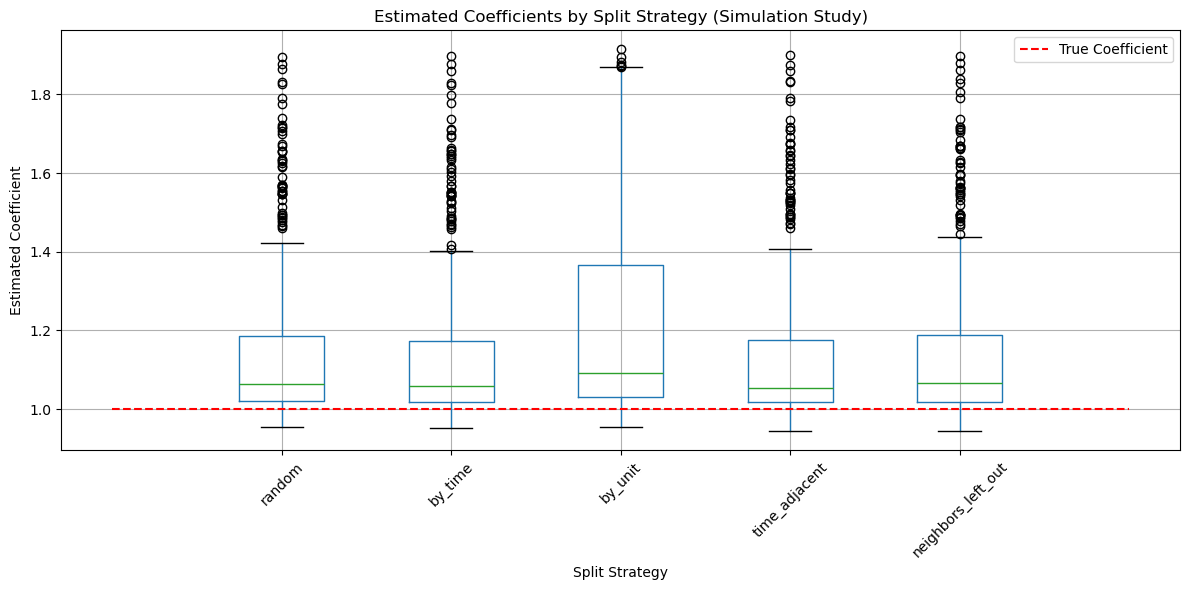

In [19]:
plt.figure(figsize=(12, 6))
results_df.boxplot()
plt.title("Estimated Coefficients by Split Strategy (Simulation Study)")
plt.ylabel("Estimated Coefficient")
plt.xlabel("Split Strategy")
plt.hlines(1, linestyles='dashed', colors='red', xmin=0, xmax=6, label="True Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()